# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import yaml

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from os import listdir
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

dataset_root_path = ROOT_DIR + "/resized"
img_folder = dataset_root_path + "/img"  #存放原图片的文件夹
mask_folder = dataset_root_path + "/mask"
yaml_folder = dataset_root_path + "/yaml"
imglist = listdir(img_folder)  #返回指定路径下的文件和文件夹列表
masklist = listdir(mask_folder)
count = len(imglist)  #文件的数目
width = 200
height = 150

#%matplotlib inline 
inter_num = 0
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


## Configurations

In [4]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 30  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1280

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                43
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
class DrugDataset(utils.Dataset):
    def get_obj_index(self, image):
        n = np.max(image)  #image是一个列表 取其最大值
        return n

    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels

    def draw_mask(self, num_obj, mask, image):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    def load_shapes(self, height, width, img_folder, mask_folder, yaml_folder, imglist):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "dumpling")
        self.add_class("shapes", 2, "tcpg")
        self.add_class("shapes", 3, "sm")
        self.add_class("shapes", 4, "qzly")
        self.add_class("shapes", 5, "potato")
        self.add_class("shapes", 6, "qchx")
        self.add_class("shapes", 7, "beefpotato")
        self.add_class("shapes", 8, "noodles")
        self.add_class("shapes", 9, "bread")
        self.add_class("shapes", 10, "mdcsg")
        self.add_class("shapes", 11, "mdcrs")
        self.add_class("shapes", 12, "gbrice")
        self.add_class("shapes", 13, "khs")
        self.add_class("shapes", 14, "currybeef")
        self.add_class("shapes", 15, "beef")
        self.add_class("shapes", 16, "hsyk")
        self.add_class("shapes", 17, "hstddpg")
        self.add_class("shapes", 18, "hspg")
        self.add_class("shapes", 19, "hsjy")
        self.add_class("shapes", 20, "hsjt")
        self.add_class("shapes", 21, "hsjk")
        self.add_class("shapes", 22, "hsdy")
        self.add_class("shapes", 23, "hsdp")
        self.add_class("shapes", 24, "dtj")
        self.add_class("shapes", 25, "cyszx")
        self.add_class("shapes", 26, "cdj")
        self.add_class("shapes", 27, "crht")
        self.add_class("shapes", 28, "bdcrs")
        self.add_class("shapes", 29, "bun")
        self.add_class("shapes", 30, "bzhx")
        for index, img in enumerate(imglist):
            img_id = imglist[index].split(".")[0]
            mask_path = ''
            for x in os.listdir(mask_folder):
                if x.startswith(img_id):
                    mask_path = mask_folder + "/" + x
            yaml_path = f'{yaml_folder}/{img_id}.yaml'
            self.add_image("shapes", image_id=index, path=f'{img_folder}/{img_id}.png',
                           width=width, height=height, mask_path=mask_path, yaml_path=yaml_path)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("dumpling") != -1:
                #print "box"
                labels_form.append("dumpling")
            elif labels[i].find("tcpg") != -1:
                #print "column"
                labels_form.append("tcpg")
            elif labels[i].find("sm") != -1:
                #print "package"
                labels_form.append("sm")
            elif labels[i].find("qzly") != -1:
                #print "fruit"
                labels_form.append("qzly")
            elif labels[i].find("potato") != -1:
                #print "fruit"
                labels_form.append("potato")
            elif labels[i].find("qchx") != -1:
                #print "fruit"
                labels_form.append("qchx")
            elif labels[i].find("beefpotato") != -1:
                #print "fruit"
                labels_form.append("beefpotato")
            elif labels[i].find("noodles") != -1:
                #print "fruit"
                labels_form.append("noodles")
            elif labels[i].find("bread") != -1:
                #print "fruit"
                labels_form.append("bread")
            elif labels[i].find("mdcsg") != -1:
                #print "fruit"
                labels_form.append("mdcsg")
            elif labels[i].find("mdcrs") != -1:
                #print "fruit"
                labels_form.append("mdcrs")
            elif labels[i].find("gbrice") != -1:
                #print "fruit"
                labels_form.append("gbrice")
            elif labels[i].find("khs") != -1:
                #print "fruit"
                labels_form.append("khs")
            elif labels[i].find("currybeef") != -1:
                #print "fruit"
                labels_form.append("currybeef")
            elif labels[i].find("hsyk") != -1:
                #print "fruit"
                labels_form.append("hsyk")
            elif labels[i].find("hstddpg") != -1:
                #print "fruit"
                labels_form.append("hstddpg")
            elif labels[i].find("hsjt") != -1:
                #print "fruit"
                labels_form.append("hsjt")
            elif labels[i].find("hsjy") != -1:
                #print "fruit"
                labels_form.append("hsjy")
            elif labels[i].find("hsdy") != -1:
                #print "fruit"
                labels_form.append("hsdy")
            elif labels[i].find("hsdp") != -1:
                #print "fruit"
                labels_form.append("hsdp")
            elif labels[i].find("dtj") != -1:
                #print "fruit"
                labels_form.append("dtj")
            elif labels[i].find("cyszx") != -1:
                #print "fruit"
                labels_form.append("cyszx")
            elif labels[i].find("cdj") != -1:
                #print "fruit"
                labels_form.append("cdj")
            elif labels[i].find("crht") != -1:
                #print "fruit"
                labels_form.append("crht")
            elif labels[i].find("bdcrs") != -1:
                #print "fruit"
                labels_form.append("bdcrs")
            elif labels[i].find("bun") != -1:
                #print "fruit"
                labels_form.append("bun")
            elif labels[i].find("bzhx") != -1:
                #print "fruit"
                labels_form.append("bzhx")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)


In [7]:
# Training dataset
#dataset_train = ShapesDataset()
#dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_train.prepare()

# Validation dataset
#dataset_val = ShapesDataset()
#dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_val.prepare()

In [8]:
#train与val数据集准备
dataset_train = DrugDataset()
dataset_train.load_shapes(150, 200, img_folder, mask_folder, yaml_folder, imglist)
dataset_train.prepare()

dataset_val = DrugDataset()
dataset_val.load_shapes(150, 200, img_folder, mask_folder, yaml_folder, imglist)
dataset_val.prepare()


IndexError: list index out of range

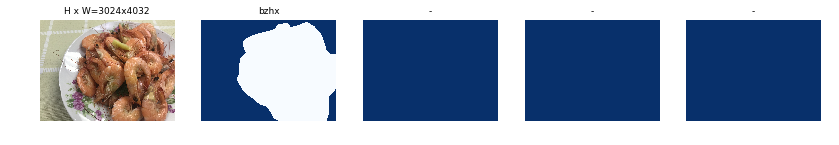

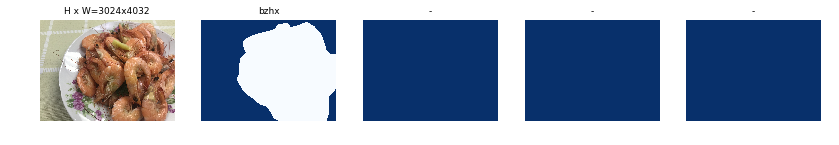

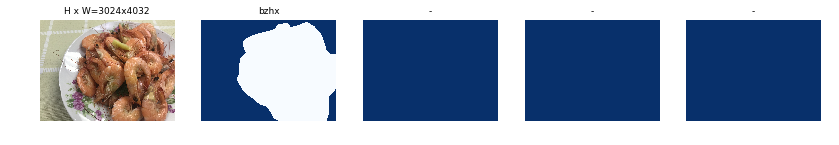

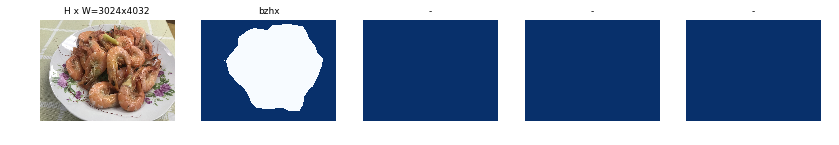

In [66]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [67]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [68]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [69]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: E:\jupytertest\Mask_RCNN-master\Mask_RCNN-master\logs\shapes20190211T2200\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b

c:\users\syh\anaconda3\envs\syhtest\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[1,512,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res3c_branch2c_3/convolution = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_235/Relu, res3c_branch2c_3/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: roi_align_classifier_3/CropAndResize/_16997 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_8617_roi_align_classifier_3/CropAndResize", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))